In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.MNIST(root='PYTORCH_NOTEBOOKS/Data/', train=True, download=True, 
                            transform=transforms.ToTensor())

train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: PYTORCH_NOTEBOOKS/Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test_data = datasets.MNIST(root='PYTORCH_NOTEBOOKS/Data/', train=False, download=True, 
                           transform=transforms.ToTensor())

test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: PYTORCH_NOTEBOOKS/Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [4]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
image, label = train_data[0]

print(f' Image Size: {image.shape} \n Label: {label}')

 Image Size: torch.Size([1, 28, 28]) 
 Label: 5


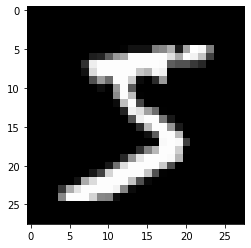

In [6]:
plt.imshow(train_data[0][0].reshape(28,28), cmap='gray')

In [7]:
## for batch processing
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)


Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


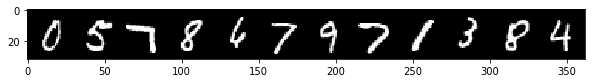

In [8]:
### printing the labels (view batch of images)

from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break
    
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

im = make_grid(images[:12], nrow=12)  # the default nrow is 8

plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the Model

In [9]:
class MNistModel(nn.Module):
    
    def __init__(self, input_size=784, output_size=10, layers=[120,80]):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)
        
    
    def forward(self,x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

In [10]:
model = MNistModel()
model

MNistModel(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [23]:
model_params = [params.numel() for params in model.parameters() if params.requires_grad]

for items in model_params:
    print(items)
    
print(f'______')
print(f'{sum(model_params)}')    

94080
120
9600
80
800
10
______
104690


In [11]:
### define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training the model

In [12]:
import time
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    # train
    for b,(X_train, y_train) in enumerate(train_loader):
        
        b+=1
        
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
                  accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    #test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.61869705                    accuracy:  82.460%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.28467241                    accuracy:  87.153%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.30361569                    accuracy:  89.123%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.23306136                    accuracy:  94.605%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.12900987                    accuracy:  94.828%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.19252619                    accuracy:  95.068%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.16168472                    accuracy:  96.270%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.14015955                    accuracy:  96.380%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.16182271                    accuracy:  96.495%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.02736050                    accuracy:  97.265%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.10580654     

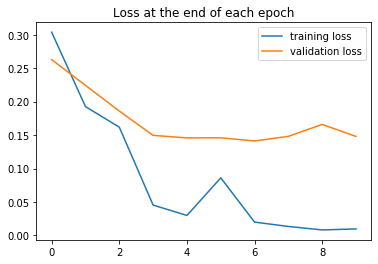

In [13]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

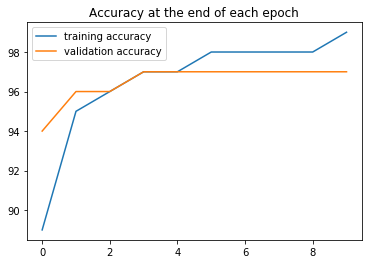

In [14]:
plt.plot([t//600 for t in train_correct], label='training accuracy')
plt.plot([t//100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [15]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

[tensor(9454), tensor(9603), tensor(9662), tensor(9713), tensor(9726), tensor(9742), tensor(9750), tensor(9742), tensor(9733), tensor(9771)]

Test accuracy: 97.710%


In [16]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [17]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9771/10000 =  97.710%
